In [1]:

import torch
from torch import nn
from torch.optim import Adam
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from simulate import SimulationDataset  
import jax
from jax import jit, vmap, grad, random, value_and_grad
import jax.numpy as jnp


### Set device

In [2]:


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device("cpu")
    print("Using CPU")



Using MPS (Apple Silicon)


### Define the parameters for the simulation

In [3]:
ns = 10000
sim = 'charge'
n = 4
dim = 2
nt = 1000
dt = 1e-3

### Generate the dataset and see the shape

In [4]:
import simulate
from simulate import SimulationDataset
simulation = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt)
simulation.simulate(ns)

In [5]:
simulation.data.shape

(10000, 500, 4, 6)

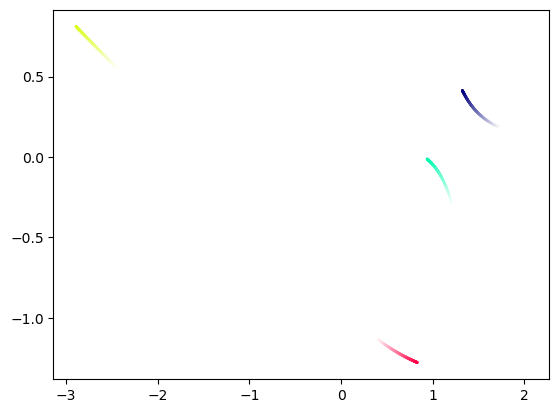

In [6]:
simulation.plot(0, animate=True, plot_size=False)

### Split the data and put into dataloader

In [7]:
accel_data = simulation.get_acceleration()

# Convert simulation and acceleration data directly to tensors
X = torch.tensor(np.array(simulation.data), dtype=torch.float32)  # Shape: (num_samples, num_time_steps, num_particles, num_features)
Y = torch.tensor(np.array(accel_data), dtype=torch.float32)       # Shape: (num_samples, num_time_steps, num_particles, output_dim)

# Select every 5th timestep along time dimension
X = X[:, ::5].reshape(-1, X.shape[2], X.shape[3])  # Flatten sample & time dims
Y = Y[:, ::5].reshape(-1, Y.shape[2], Y.shape[3])  # Flatten sample & time dims

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False)

In [8]:
print(X_train.shape,X_test.shape, Y_train.shape, Y_test.shape)

torch.Size([750000, 4, 6]) torch.Size([250000, 4, 6]) torch.Size([750000, 4, 2]) torch.Size([250000, 4, 2])


In [9]:
from models import NbodyGNN,get_edge_index

edge_index = get_edge_index(n, sim)


from torch_geometric.data import Data, DataLoader

train_data_list = [
    Data(
        x=X_train[i],  
        edge_index=edge_index,  
        y=Y_train[i]
    ) for i in range(len(Y_train))
]

test_data_list = [
    Data(
        x=X_test[i],  
        edge_index=edge_index,  
        y=Y_test[i]
    ) for i in range(len(Y_test))
]


batch = int(64 * (4 / n) ** 2)

trainloader = DataLoader(train_data_list, batch_size=batch, shuffle=True)
testloader = DataLoader(test_data_list, batch_size=1024, shuffle=False)


/Users/liuyihao/Desktop/DIS-final-project/src/models.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_e3pikzc5fh/croot/libtorch_1738337599132/work/torch/csrc/utils/tensor_new.cpp:281.)
  edge_index = torch.tensor([row, col], dtype=torch.long)
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Standard model

In [ ]:
aggr = 'add'
hidden = 300
msg_dim = 100
n_f = simulation.data.shape[3]


NameError: name 'simulation' is not defined

In [11]:
from torch.optim.lr_scheduler import OneCycleLR
initial_learing_rate = 1e-3


total_epochs = 30


batch_per_epoch = len(trainloader)


batch_per_epoch

11719

In [12]:

model_standard = NbodyGNN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)

opt_standard = torch.optim.Adam(model_standard.parameters(), lr=initial_learing_rate, weight_decay=1e-8)


sched_standard = OneCycleLR(opt_standard, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [13]:
import wandb
wandb.init(project="DIS-final-project", name="Train-charge-standard", reinit=True)

for epoch in range(total_epochs):
    model_standard.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_standard.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_standard.loss(batch)
        loss.backward()
        opt_standard.step()
        sched_standard.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})


/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
wandb: Currently logged in as: liuyihao649 (liuyihao649-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/30, Loss: 74.585208
Epoch 2/30, Loss: 69.393876
Epoch 3/30, Loss: 65.338150
Epoch 4/30, Loss: 61.521475
Epoch 5/30, Loss: 52.427935
Epoch 6/30, Loss: 47.030695
Epoch 7/30, Loss: 46.715962
Epoch 8/30, Loss: 46.467088
Epoch 9/30, Loss: 46.762352
Epoch 10/30, Loss: 45.520011
Epoch 11/30, Loss: 45.162163
Epoch 12/30, Loss: 43.637524
Epoch 13/30, Loss: 43.068840
Epoch 14/30, Loss: 41.875065
Epoch 15/30, Loss: 40.984349
Epoch 16/30, Loss: 40.036106
Epoch 17/30, Loss: 38.752427
Epoch 18/30, Loss: 37.292644
Epoch 19/30, Loss: 35.798856
Epoch 20/30, Loss: 34.523502
Epoch 21/30, Loss: 32.336655
Epoch 22/30, Loss: 30.498777
Epoch 23/30, Loss: 27.789371
Epoch 24/30, Loss: 24.854244
Epoch 25/30, Loss: 21.771116
Epoch 26/30, Loss: 19.098675
Epoch 27/30, Loss: 16.318953
Epoch 28/30, Loss: 14.201765
Epoch 29/30, Loss: 12.795037
Epoch 30/30, Loss: 12.154426


In [14]:
# Save the model state
import os

root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "charge_standard.pth")

torch.save(model_standard.state_dict(), save_path)

In [15]:
import os
model_standard = NbodyGNN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)
root_checkpoints = os.path.join("..", "model_weights")
os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "charge_standard.pth")
state_dict = torch.load(save_path, map_location=device)
model_standard.load_state_dict(state_dict)


model_standard.eval()

/var/folders/t1/80vwgky503qdx678h0vqjcmw0000gn/T/ipykernel_99325/1287856261.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path, map_locati

NbodyGNN()

In [16]:
model_standard.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_standard(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 2.428472


Selected channels: ['msg78', 'msg65']


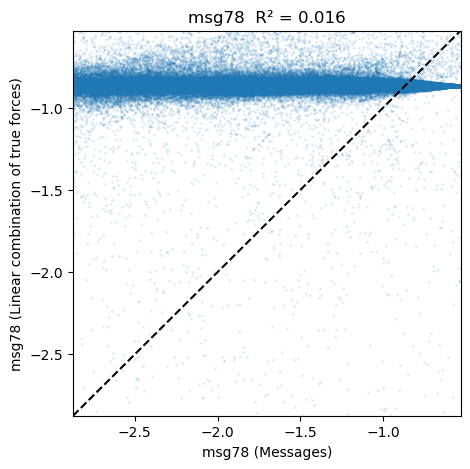

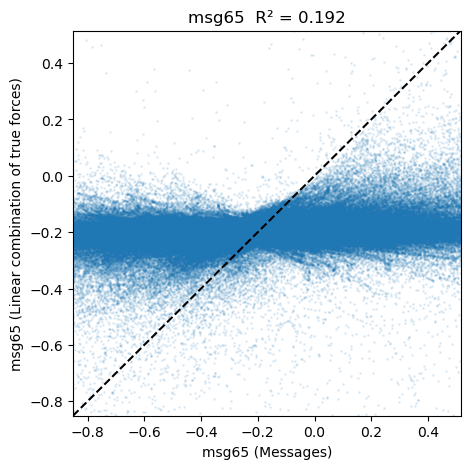

In [17]:

from message_processing import measure_latent, fit_multioutput_force
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Measure latent variables
latent_df_standard = measure_latent(model_standard, testloader, device=device, dim=dim, msg_dim=msg_dim)

# compute true force components and add them to latent_df
latent_df_standard['fx_true'] = (latent_df_standard['q1'] * latent_df_standard['q2']) * \
                    (latent_df_standard['dx'] / (latent_df_standard['r'] ** 3 + 1e-5))
latent_df_standard['fy_true'] = (latent_df_standard['q1'] * latent_df_standard['q2']) * \
                    (latent_df_standard['dy'] / (latent_df_standard['r'] ** 3 + 1e-5))

# Fit multi-output linear regression to find top channels
lr, top_channels= fit_multioutput_force(latent_df_standard, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_standard[['fx_true','fy_true']].values

# True messages
Messages = latent_df_standard[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

# 
for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]          
    y_pred_ch = Predicted_messages[:, idx] 

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true_ch, y_pred_ch, s=1, alpha=0.1)
    plt.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    plt.xlim(p_lower, p_upper)
    plt.ylim(p_lower, p_upper)
    plt.xlabel(f"{ch} (Messages)")
    plt.ylabel(f"{ch} (Linear combination of true forces)")

    single_r2 = r2_score(y_true_ch, y_pred_ch)
    plt.title(f"{ch}  R² = {single_r2:.3f}")
    plt.show()


In [18]:
import pysr
sr_standard= pysr.PySRRegressor(
  niterations=80,
  binary_operators=["+", "-", "*", "/"]
)
df_sub_standard = latent_df_standard[['dx','dy','r','q1','q2', top_channels[0]]].sample(5000)
X = df_sub_standard[['dx','dy','r','q1','q2']].values
Y = df_sub_standard[top_channels[0]].values
sr_standard.fit(X, Y)
print(sr_standard)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


NameError: name 'latent_df_standard' is not defined

### Bottleneck model

In [12]:

msg_dim_bottleneck=2

model_bottleneck = NbodyGNN(n_f, msg_dim_bottleneck, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)

opt_bottleneck = torch.optim.Adam(model_bottleneck.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_bottleneck = OneCycleLR(opt_bottleneck, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)


In [13]:
import wandb
wandb.init(project="DIS-final-project", name="Train-charge-bottleneck", reinit=True)
for epoch in range(total_epochs):
    model_bottleneck.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_bottleneck.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_bottleneck.loss(batch)
        loss.backward()
        opt_bottleneck.step()
        sched_bottleneck.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
wandb: Currently logged in as: liuyihao649 (liuyihao649-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/30, Loss: 76.261394
Epoch 2/30, Loss: 71.271445
Epoch 3/30, Loss: 67.854305
Epoch 4/30, Loss: 65.843621
Epoch 5/30, Loss: 63.645501
Epoch 6/30, Loss: 59.175401
Epoch 7/30, Loss: 54.021616
Epoch 8/30, Loss: 49.324880
Epoch 9/30, Loss: 46.952427
Epoch 10/30, Loss: 45.815728
Epoch 11/30, Loss: 44.897139
Epoch 12/30, Loss: 44.211233
Epoch 13/30, Loss: 43.529891
Epoch 14/30, Loss: 42.819100
Epoch 15/30, Loss: 41.740514
Epoch 16/30, Loss: 40.935555
Epoch 17/30, Loss: 39.919674
Epoch 18/30, Loss: 38.929995
Epoch 19/30, Loss: 36.827635
Epoch 20/30, Loss: 35.411258
Epoch 21/30, Loss: 33.762463
Epoch 22/30, Loss: 31.499278
Epoch 23/30, Loss: 29.536081
Epoch 24/30, Loss: 26.936139
Epoch 25/30, Loss: 24.350070
Epoch 26/30, Loss: 21.604392
Epoch 27/30, Loss: 19.054915
Epoch 28/30, Loss: 17.325071
Epoch 29/30, Loss: 16.119449
Epoch 30/30, Loss: 15.590858


In [14]:
import os


root_checkpoints = os.path.join("..", "model_weights")

os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "charge_bottleneck.pth")

torch.save(model_bottleneck.state_dict(), save_path)

In [15]:
model_bottleneck.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_bottleneck(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 2.636568


Selected channels: ['msg0', 'msg1']


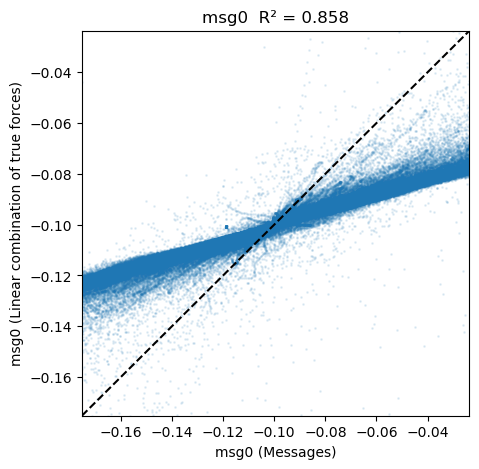

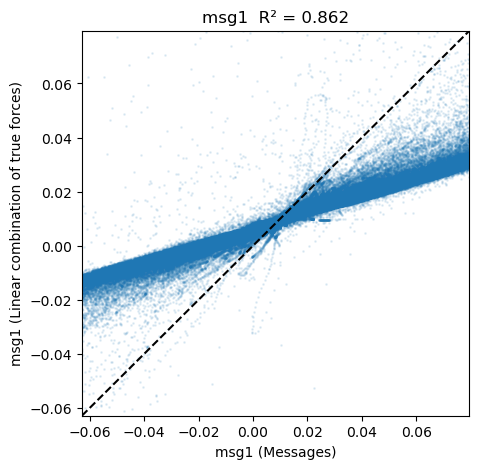

In [17]:
from message_processing import measure_latent, fit_multioutput_force
from sklearn.metrics import r2_score


# Measure latent variables
latent_df_bottleneck = measure_latent(model_bottleneck, testloader, device=device, dim=dim, msg_dim=msg_dim_bottleneck)

# compute true force components and add them to latent_df
latent_df_bottleneck['fx_true'] = (latent_df_bottleneck['q1'] * latent_df_bottleneck['q2']) * \
                    (latent_df_bottleneck['dx'] / (latent_df_bottleneck['r'] ** 3 + 1e-5))
latent_df_bottleneck['fy_true'] = (latent_df_bottleneck['q1'] * latent_df_bottleneck['q2']) * \
                    (latent_df_bottleneck['dy'] / (latent_df_bottleneck['r'] ** 3 + 1e-5))

# Fit multi-output linear regression to find top channels
lr, top_channels = fit_multioutput_force(latent_df_bottleneck, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_bottleneck[['fx_true', 'fy_true']].values

# True messages
Messages = latent_df_bottleneck[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true_ch, y_pred_ch, s=1, alpha=0.1)
    plt.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    plt.xlim(p_lower, p_upper)
    plt.ylim(p_lower, p_upper)
    plt.xlabel(f"{ch} (Messages)")
    plt.ylabel(f"{ch} (Linear combination of true forces)")

    single_r2 = r2_score(y_true_ch, y_pred_ch)
    plt.title(f"{ch}  R² = {single_r2:.3f}")
    plt.show()

In [1]:
import pysr
sr_bottleneck = pysr.PySRRegressor(
    niterations=80,
    binary_operators=["+", "-", "*", "/","^"]
)
df_sub_bottleneck = latent_df_bottleneck[['dx', 'dy', 'r', 'q1','q2', top_channels[0]]].sample(5000)
X = df_sub_bottleneck[['dx', 'dy', 'r','q1','q2']].values
Y = df_sub_bottleneck[top_channels[0]].values
sr_bottleneck.fit(X, Y)
print(sr_bottleneck)



Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


NameError: name 'latent_df_bottleneck' is not defined

### L1 regularization model

In [20]:
model_l1 = NbodyGNN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0.02).to(device)

opt_l1 = torch.optim.Adam(model_l1.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_l1 = OneCycleLR(opt_l1, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [21]:
wandb.init(project="DIS-final-project", name="Train-charge-l1", reinit=True)
for epoch in range(total_epochs):
    model_l1.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_l1.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_l1.loss(batch)
        loss.backward()
        opt_l1.step()
        sched_l1.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▇▇▇▇▆▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁
epoch,30
train_loss,15.59086


Epoch 1/30, Loss: 79.393337
Epoch 2/30, Loss: 78.286439
Epoch 3/30, Loss: 75.115756
Epoch 4/30, Loss: 67.590935
Epoch 5/30, Loss: 57.796935
Epoch 6/30, Loss: 55.555894
Epoch 7/30, Loss: 55.482734
Epoch 8/30, Loss: 54.961321
Epoch 9/30, Loss: 54.086471
Epoch 10/30, Loss: 52.885371
Epoch 11/30, Loss: 51.623668
Epoch 12/30, Loss: 50.682020
Epoch 13/30, Loss: 49.602847
Epoch 14/30, Loss: 48.041520
Epoch 15/30, Loss: 47.390607
Epoch 16/30, Loss: 45.476964
Epoch 17/30, Loss: 44.335852
Epoch 18/30, Loss: 42.461248
Epoch 19/30, Loss: 40.571544
Epoch 20/30, Loss: 38.601425
Epoch 21/30, Loss: 36.647525
Epoch 22/30, Loss: 34.358415
Epoch 23/30, Loss: 31.720093
Epoch 24/30, Loss: 29.723693
Epoch 25/30, Loss: 26.680533
Epoch 26/30, Loss: 23.987904
Epoch 27/30, Loss: 21.140947
Epoch 28/30, Loss: 19.186146
Epoch 29/30, Loss: 17.804322
Epoch 30/30, Loss: 17.275001


In [22]:
import os


root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "charge_l1.pth")

torch.save(model_l1.state_dict(), save_path)

In [23]:
model_l1.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_l1(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 2.743050


Selected channels: ['msg39', 'msg46']


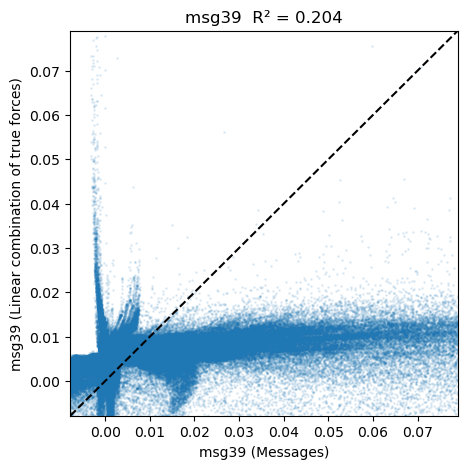

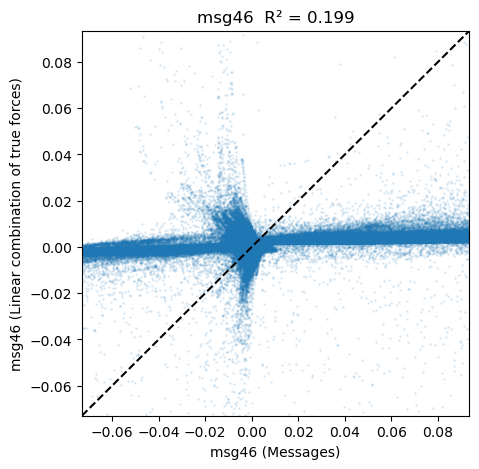

In [24]:
# Measure latent variables
latent_df_l1 = measure_latent(model_l1, testloader, device=device, dim=dim, msg_dim=msg_dim)

# compute true force components and add them to latent_df
latent_df_l1['fx_true'] = (latent_df_l1['q1'] * latent_df_l1['q2']) * \
                    (latent_df_l1['dx'] / (latent_df_l1['r'] ** 3 + 1e-5))
latent_df_l1['fy_true'] = (latent_df_l1['q1'] * latent_df_l1['q2']) * \
                    (latent_df_l1['dy'] / (latent_df_l1['r'] ** 3 + 1e-5))


# Fit multi-output linear regression to find top channels
lr, top_channels = fit_multioutput_force(latent_df_l1, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_l1[['fx_true', 'fy_true']].values

# True messages
Messages = latent_df_l1[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true_ch, y_pred_ch, s=1, alpha=0.1)
    plt.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    plt.xlim(p_lower, p_upper)
    plt.ylim(p_lower, p_upper)
    plt.xlabel(f"{ch} (Messages)")
    plt.ylabel(f"{ch} (Linear combination of true forces)")

    single_r2 = r2_score(y_true_ch, y_pred_ch)
    plt.title(f"{ch}  R² = {single_r2:.3f}")
    plt.show()


In [ ]:
import pysr
sr_l1 = pysr.PySRRegressor(
    niterations=70,
    binary_operators=["+", "-", "*", "/", "^" ]  
)
df_sub_l1 = latent_df_l1[['dx', 'dy', 'r', 'q1','q2',top_channels[0]]].sample(5000)
X = df_sub_l1[['dx', 'dy', 'r','q1','q2']].values
Y = df_sub_l1[top_channels[0]].values
sr_l1.fit(X, Y)
print(sr_l1)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 1.960e+05
Progress: 1132 / 2170 total iterations (52.166%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.035e-04  1.594e+01  y = 0
3           1.269e-04  4.360e-01  y = x₀ * 0.011393
5           8.395e-05  2.066e-01  y = (x₂ * 0.005452) * x₀
7           3.783e-05  3.986e-01  y = (x₁ + (x₀ * x₂)) * 0.0054391
9           2.778e-05  1.544e-01  y = (((x₀ * 1.8906) + x₁) * x₂) * 0.0027839
11          2.358e-05  8.187e-02  y = (x₀ + x₁) * (((x₂ + -0.98905) * 0.018562) / x₂)
13          4.822e-07  1.945e+00  y = ((x₂ + -0.98641) / (x₂ * 82.033)) * (x₀ + (x₁ + x₀))
15          3.824e-07  1.159e-01  y = (((x₁ * 1.0195) + x₀) + x₀) * ((x₂ + -0.98641) / (x₂ *...
                                       82.033))
17          3.205e-07  8.830e-02  y = ((x₂ + 

### KL divergence model

In [25]:
from models import VariationNbody

In [26]:
model_kl = VariationNbody(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), beta=1.0).to(device)

opt_kl = torch.optim.Adam(model_kl.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_kl = OneCycleLR(opt_kl, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [27]:
import wandb
wandb.init(project="DIS-final-project-kl", name="Train-charge", reinit=True)
for epoch in range(total_epochs):
    model_kl.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_kl.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_kl.loss(batch)
        loss.backward()
        opt_kl.step()
        sched_kl.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,███▇▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁
epoch,30
train_loss,17.275


Epoch 1/30, Loss: 9.883627
Epoch 2/30, Loss: 9.854715
Epoch 3/30, Loss: 9.839599
Epoch 4/30, Loss: 9.833823
Epoch 5/30, Loss: 9.809973
Epoch 6/30, Loss: 9.739597
Epoch 7/30, Loss: 9.725716
Epoch 8/30, Loss: 9.725032
Epoch 9/30, Loss: 9.721978
Epoch 10/30, Loss: 9.700510
Epoch 11/30, Loss: 9.665165
Epoch 12/30, Loss: 9.583152
Epoch 13/30, Loss: 9.500425
Epoch 14/30, Loss: 9.439834
Epoch 15/30, Loss: 9.378559
Epoch 16/30, Loss: 9.338575
Epoch 17/30, Loss: 9.162217
Epoch 18/30, Loss: 8.781289
Epoch 19/30, Loss: 8.508173
Epoch 20/30, Loss: 8.289375
Epoch 21/30, Loss: 7.950768
Epoch 22/30, Loss: 7.600929
Epoch 23/30, Loss: 7.308135
Epoch 24/30, Loss: 7.085429
Epoch 25/30, Loss: 6.828999
Epoch 26/30, Loss: 6.536785
Epoch 27/30, Loss: 6.340951
Epoch 28/30, Loss: 6.144002
Epoch 29/30, Loss: 6.030117
Epoch 30/30, Loss: 5.972402


In [28]:
import os


root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "charge_kl.pth")

torch.save(model_kl.state_dict(), save_path)

In [29]:
model_kl.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_kl(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 6.067025


Top μ channels: ['mu69', 'mu91']
Multi-output μ‐linear fit R² = 0.1686


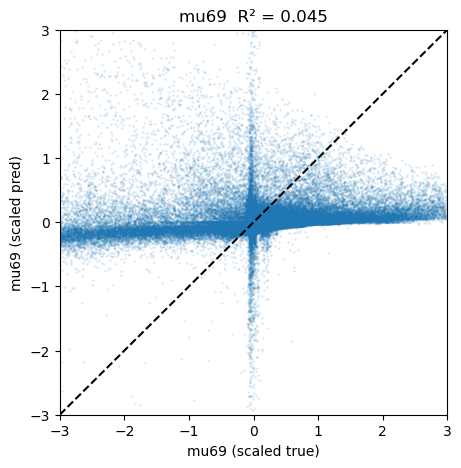

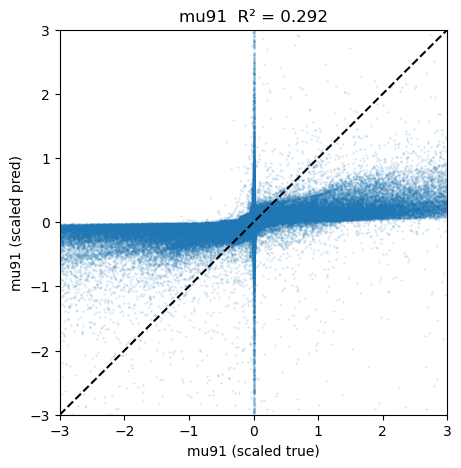

In [30]:
from message_processing import measure_variational_latent
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score   

df = measure_variational_latent(
    model_kl, testloader, device=device,
    dim=dim, msg_dim=msg_dim
)

# 1) 选出方差最大的 dim 个 mu 通道
mu_cols = [c for c in df.columns if c.startswith("mu")]
top_mu  = df[mu_cols].std().nlargest(dim).index.tolist()
print("Top μ channels:", top_mu)

# 2) 计算真实力，并拼成 X
df['fx_true'] = (df['q1'] * df['q2']) * (df['dx'] / (df['r'] ** 3 + 1e-5))
df['fy_true'] = (df['q1'] * df['q2']) * (df['dy'] / (df['r'] ** 3 + 1e-5))


X_raw = df[['fx_true','fy_true']].values       # (N,2)
Y_mu   = df[top_mu].values                     # (N,dim)

# 3) 标准化
scaler_X  = StandardScaler().fit(X_raw)
scaler_Ymu = StandardScaler().fit(Y_mu)
Xs  = scaler_X.transform(X_raw)
Ysm = scaler_Ymu.transform(Y_mu)

# 4) 拟合 & 得到整体 R²
lr_mu = LinearRegression().fit(Xs, Ysm)
r2_mu = lr_mu.score(Xs, Ysm)
print(f"Multi-output μ‐linear fit R² = {r2_mu:.4f}")

# 5) 可视化：每个 μ 通道的真值 vs 预测
for i, ch in enumerate(top_mu):
    Y_true = Ysm[:, i]
    Y_pred = lr_mu.predict(Xs)[:, i]

    plt.figure(figsize=(5,5))
    plt.scatter(Y_true, Y_pred, s=1, alpha=0.1)
    plt.plot([-3,3],[-3,3],'k--')
    plt.xlim(-3,3); plt.ylim(-3,3)
    plt.xlabel(f"{ch} (scaled true)")
    plt.ylabel(f"{ch} (scaled pred)")
    r2_chan = r2_score(Y_true, Y_pred)
    plt.title(f"{ch}  R² = {r2_chan:.3f}")
    plt.show()

In [ ]:

import pysr
sr_kl = pysr.PySRRegressor(
    niterations=70,
    binary_operators=["+", "-", "*", "/", "^" ]
)
df_sub_kl = df[['dx', 'dy', 'r', 'q1','q2',top_mu[0]]].sample(5000)
X = df_sub_kl[['dx', 'dy', 'r','q1','q2']].values
Y = df_sub_kl[top_mu[0]].values
sr_kl.fit(X, Y)
print(sr_kl)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 2.070e+05
Progress: 1153 / 2170 total iterations (53.134%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.436e-01  1.594e+01  y = 0.0031465
3           2.429e-01  1.734e-01  y = x₀ * 0.26836
5           2.214e-01  4.634e-02  y = (x₁ + x₀) * 0.20792
7           2.025e-01  4.451e-02  y = ((x₂ * x₀) + x₁) * 0.12208
9           1.986e-01  9.826e-03  y = (x₂ * ((x₁ * 0.5595) + x₀)) * 0.11742
11          1.918e-01  1.732e-02  y = ((x₂ + -0.9262) * (0.41094 / x₂)) * (x₀ + x₁)
13          1.786e-01  3.565e-02  y = (((x₂ + -0.93149) * (x₀ + (x₁ * 0.54348))) * 0.5349) /...
                                       x₂
15          1.766e-01  5.757e-03  y = ((x₁ + x₀) + x₀) * (((0.36238 / x₂) - 0.034037) * (x₂ ...
                                      + -0.940